# Naive implementation of statevector simulation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
# Gate Definitions
X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
I = np.eye(2)
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

In [4]:
import pennylane as qml
import pennylane.numpy as np

#### Quantum Circuit simulation using Pennylane

In [4]:
def apply_quantum(qubits):
    dev = qml.device("lightning.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(qubits):
        for wire in range(qubits):
            qml.QubitUnitary(X, wires=wire)
            qml.QubitUnitary(H, wires=wire)
        for wire in range(qubits-1):
            qml.QubitUnitary(CNOT, wires=[wire,wire+1])
        return qml.state()
    
    state = circuit(qubits)
    return state

# Run Circuit with Matrix Multiplication
state1 = apply_quantum(4)
state1

array([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j])

In [5]:
# Runtime Plot
qubits = range(1, 25)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_quantum(n))
    times.append(time.time() - start)

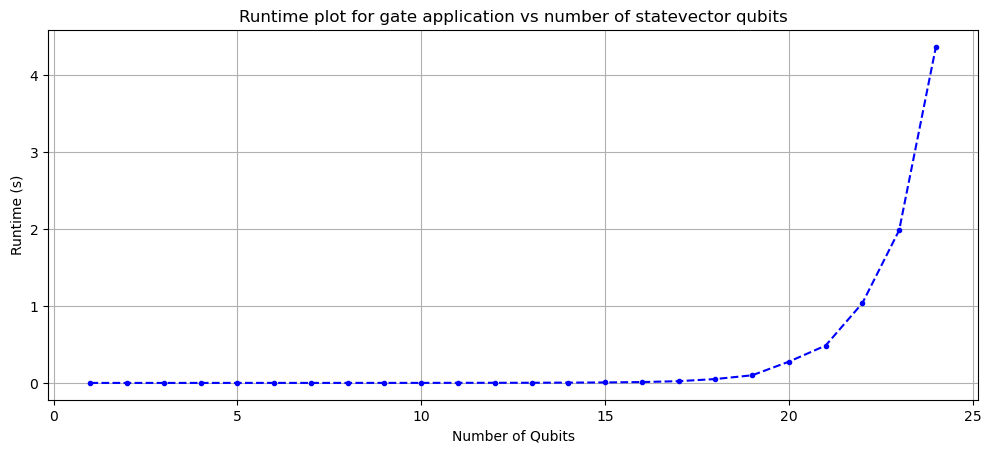

In [6]:
plt.style.use("seaborn-v0_8-dark-palette")
plt.figure().set_figwidth(12)
plt.grid()
plt.title("Runtime plot for gate application vs number of statevector qubits")
plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

# Task 1 : Subtask 1

### Using only matrix multiplication

In [7]:
# so we already have our operators, now we will calculate time required for computation.
def init_state(qubits):
    state = [1+0j,0]
    for _ in range(qubits-1):
        state = np.kron(state,[1,0])
    return state

In [8]:
print(len(init_state(4)))
init_state(4)

16


tensor([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], requires_grad=True)

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Operator

# function to calculate the cnot cascaded cnot operator for multiple qubits
def cnot_op(qubits):
    c = QuantumCircuit(qubits)
    for i in range(qubits-1):
        c.cx(i+1,i)
    #print(c)
    matrix = Operator.from_circuit(c)
    return matrix.data

In [10]:
print("sample: cnot operator for 2 qubits")
cnot_op(2)

sample: cnot operator for 2 qubits


array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [11]:
cnot_op(4).shape[0]

16

In [12]:
def apply_numpy(qubits):
    initial_state = init_state(qubits)
    xop= 1
    hop= 1
    cnotop = cnot_op(qubits)
    state_vec = initial_state
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    
    state_vec = np.dot(np.dot(hop,xop),state_vec)
    state_vec = np.dot(cnotop,state_vec)
    return state_vec

# Run Circuit with Matrix Multiplication
state2 = apply_numpy(4)
state2

tensor([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j], requires_grad=True)

In [13]:
# Runtime Plot
qubits = range(1, 12)
times_with_qiskit = []
states_with_qiskit = []
for n in qubits:
    start = time.time()
    states_with_qiskit.append(apply_numpy(n))
    times_with_qiskit.append(time.time() - start)

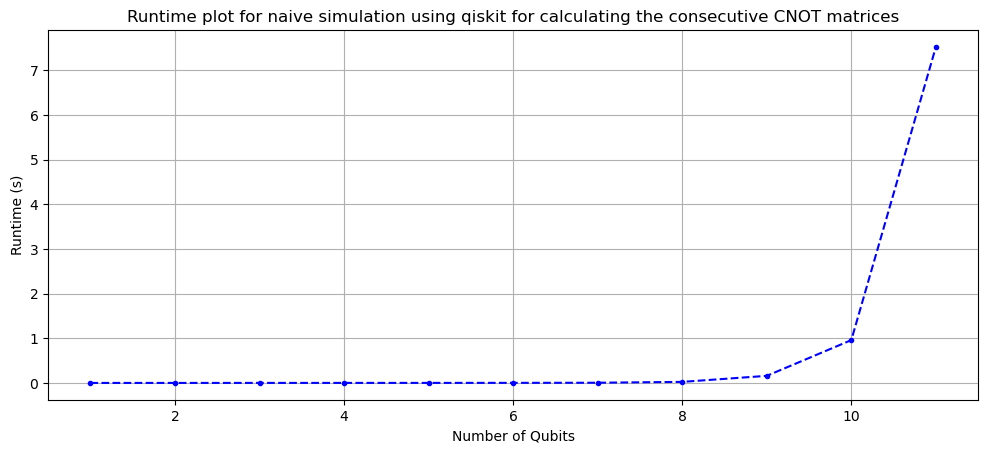

In [14]:
plt.style.use("seaborn-v0_8-dark-palette")
plt.figure().set_figwidth(12)
plt.title("Runtime plot for naive simulation using qiskit for calculating the consecutive CNOT matrices")
plt.grid()
plt.plot(qubits, times_with_qiskit,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

The simulation is run for max 12 qubits because classical matrix algrbra using the naive method beyond that limit becomes increasingly difficult.

## Without using the qiskit functionality for cnot gate

In [15]:
np.shape(CNOT)[0]

4

Direct sum function which would give the matrix direct sum $c = a \oplus b$ for operator calculation for multi qubit states.

In [16]:
def direct_sum(a, b):
    m1, n1 = np.shape(a)
    m2, n2 = np.shape(b)
    c = np.zeros((m1 + m2, n1 + n2))
    
    c[:m1, :n1] = a   
    c[m1:, n1:] = b
    return c

direct_sum(np.ones((2,2)),[[9,9],[9,9]])

tensor([[1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 0., 9., 9.],
        [0., 0., 9., 9.]], requires_grad=True)

#### Now we develop a function which implements the plain numpy method without using the qiskit functionality

In [17]:
def apply_numpy_without_qiskit(qubits):
    initial_state = init_state(qubits)
    xop = 1
    hop = 1
    cnotop = 1
    state_vec = initial_state
    
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    for _ in range(qubits//2):
        cnotop = np.kron(cnotop,CNOT)
    
    if not qubits%2==0 and qubits > 1:
        dims = np.shape(cnotop)[0]
        cnotop = direct_sum(np.eye(dims),cnotop)
    
    state_vec = np.dot(np.dot(hop,xop),state_vec)
    state_vec = np.dot(cnotop,state_vec)
    #print(cnotop)
    return state_vec

# Run Circuit with Matrix Multiplication
state3 = apply_numpy_without_qiskit(3)
state3, state3.shape

(tensor([ 0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j,
          0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j,
         -0.35355339+0.j,  0.35355339+0.j], requires_grad=True),
 (8,))

In [18]:
# Runtime Plot
qubits = range(1, 12)
times_without_qiskit = []
states_without_qiskit = []
for n in qubits:
    start = time.time()
    states_without_qiskit.append(apply_numpy_without_qiskit(n))
    times_without_qiskit.append(time.time() - start)

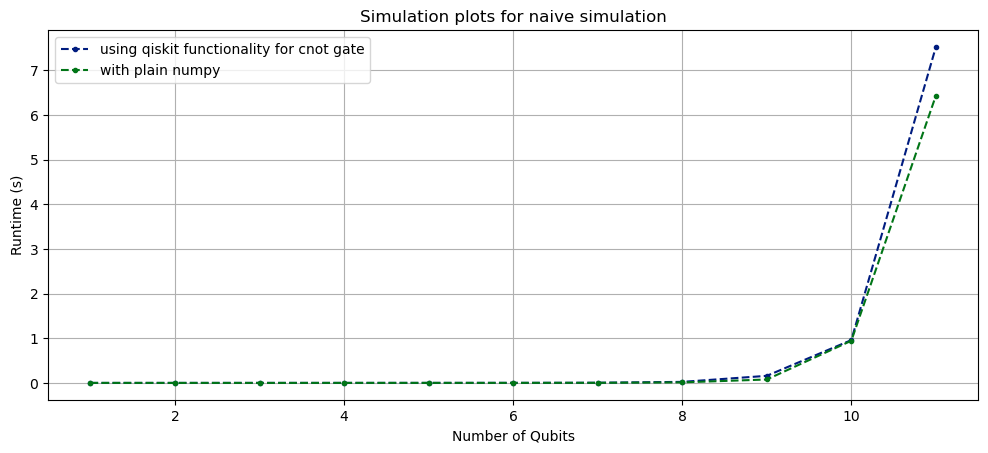

In [19]:
plt.style.use("seaborn-v0_8-dark-palette")
plt.figure().set_figwidth(12)
plt.title("Simulation plots for naive simulation")
plt.grid()
plt.plot(qubits, times_with_qiskit,marker = ".",ls = "--",label = "using qiskit functionality for cnot gate")
plt.plot(qubits, times_without_qiskit,marker = ".",ls = "--",label = "with plain numpy")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

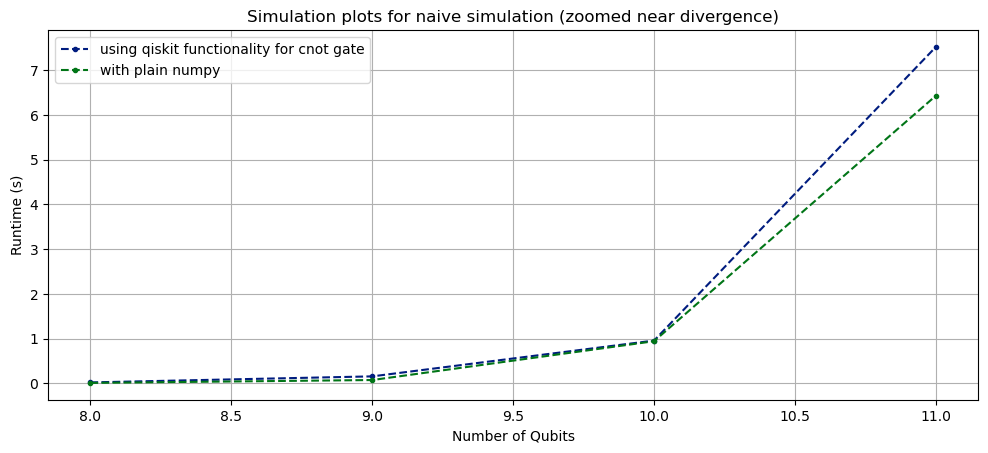

In [20]:
plt.style.use("seaborn-v0_8-dark-palette")
plt.figure().set_figwidth(12)
plt.title("Simulation plots for naive simulation (zoomed near divergence)")
plt.grid()
plt.plot(qubits[7:], times_with_qiskit[7:],marker = ".",ls = "--",label = "using qiskit functionality for cnot gate")
plt.plot(qubits[7:], times_without_qiskit[7:],marker = ".",ls = "--",label = "with plain numpy")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

As expected the additional usage of qiskit to extract the CNOT gate takes slightly more time, although only for basic linear algebraic calculations still as is shown the time adds up.

# Tensor method

In this case instead of using the numpy method we use the tensor method where ibstead of using a 1D vector we use tensor shapes. Therefore instead of representing $|00\rangle$ as `[1,0,0,0]`we instead represent it as `[[1,0],[1,0]]`.

For the Tensor simulation program we convert every operator into a shape ((2,)* n). 

In [5]:
CNOT = CNOT.reshape([2]*4)+0j
CNOT, X+0j, H+0j, I+0j # generalizing operators into complex entries

(array([[[[1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j]]],
 
 
        [[[0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]],
 
         [[0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j]]]]),
 array([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]),
 array([[ 0.70710678+0.j,  0.70710678+0.j],
        [ 0.70710678+0.j, -0.70710678+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]))

#### Now we define a TensorSimulator class for single qubit application and 2 qubit application.

In [6]:
class TensorSimulator:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.state = np.zeros((2,) * n_qubits)
        self.state[(0,) * n_qubits] = 1.0
        
    def apply_single_qubit_gate(self, gate, target):
        # Tensordot product is applied to the first "sub-vector".
        self.state = np.tensordot(self.state, gate, axes=(target, 1))
        
        # Now we need to rearrange it properly.
        axes = list(range(self.n_qubits))
        axes.insert(target, self.n_qubits-1)
        axes.pop()
        self.state = np.transpose(self.state, axes)

    def apply_two_qubit_gate(self, gate, control, target):
        if len(self.state.shape) > 1:
            # Apply CNOT
            self.state = np.tensordot(self.state, gate, axes=([control, target], [0, 1]))
            
            # rearrange axes
            axes = list(range(self.n_qubits))
            axes.insert(control,self.n_qubits-2)
            axes.insert(target,self.n_qubits-1)
            axes.pop()
            axes.pop()
            self.state = np.transpose(self.state, axes)

### Examples to show the operations of this TensorCircuitSimulator class for 3 and 4 qubit systems

#### Example 1

Pauli X

In [24]:
q1 = TensorSimulator(3)
print("init at |000>")
q1.state

init at |000>


tensor([[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]], requires_grad=True)

In [25]:
q1.apply_single_qubit_gate(X,0)
print("now (X,0) gives |100>")
q1.state

now (X,0) gives |100>


tensor([[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 0.]]], requires_grad=True)

In [26]:
q1.apply_single_qubit_gate(X,1)
print("Now (X,1) gives |110>")
q1.state

Now (X,1) gives |110>


tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 0.]]], requires_grad=True)

In [27]:
q1.apply_single_qubit_gate(X,2)
print("Now (X,2) gives |111>")
q1.state

Now (X,2) gives |111>


tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 1.]]], requires_grad=True)

Hadamard

In [28]:
q2 = TensorSimulator(3)
q2.apply_single_qubit_gate(H,0)
print("Hadamard at 0 gives |+00> = 1/sqrt2 (|000> + |100>)")
q2.state

Hadamard at 0 gives |+00> = 1/sqrt2 (|000> + |100>)


tensor([[[0.70710678, 0.        ],
         [0.        , 0.        ]],

        [[0.70710678, 0.        ],
         [0.        , 0.        ]]], requires_grad=True)

In [29]:
q2.apply_single_qubit_gate(H,0)
q2.apply_single_qubit_gate(H,1)
print("Now Hadamard at 1 gives |0+0> = 1/sqrt2 (|000> + |010>)")
q2.state

Now Hadamard at 1 gives |0+0> = 1/sqrt2 (|000> + |010>)


tensor([[[0.70710678, 0.        ],
         [0.70710678, 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]], requires_grad=True)

In [30]:
q2.apply_single_qubit_gate(H,1)
q2.apply_single_qubit_gate(H,2)
print("Hadamard at 0 gives |+00> = 1/sqrt2 (|000> + |001>)")
q2.state

Hadamard at 0 gives |+00> = 1/sqrt2 (|000> + |001>)


tensor([[[0.70710678, 0.70710678],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]], requires_grad=True)

We have shown that using Tensor method my single qubit gates are perfectly working

#### Example 2

In [31]:
qq = TensorSimulator(4)
qq.apply_single_qubit_gate(X,0)
qq.apply_single_qubit_gate(X,1)
print("state is now |1100>")
qq.state

state is now |1100>


tensor([[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[1., 0.],
          [0., 0.]]]], requires_grad=True)

In [32]:
qq.apply_two_qubit_gate(CNOT,0,2)
print("Now we apply CNOT to control = 0 & target = 2 which should ideally give us |1110>")
qq.state

Now we apply CNOT to control = 0 & target = 2 which should ideally give us |1110>


tensor([[[[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]]],


        [[[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j]]]], requires_grad=True)

In [36]:
qq.apply_two_qubit_gate(CNOT,1,3)
print("Now we apply CNOT to control = 1,target = 3 t0 |1110> which should give us |1111>")
qq.state

Now we apply CNOT to control = 1,target = 3 t0 |1110> which should give us |1111>


tensor([[[[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]]],


        [[[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]]]], requires_grad=True)

As we can clearly see here that our two qubit gate works perfectly fine as well.

### Plotter function

In [33]:
def plot_tensor_simulation(max_qubits):
    times = []
    qubits = list(range(2, max_qubits + 1))
    
    for n in qubits:
        start = time.time()
        
        # Create and run a test circuit
        sim = TensorSimulator(n)
        for i in range(n-1):
            sim.apply_single_qubit_gate(X, i)
            sim.apply_single_qubit_gate(H, 0)
        
        sim.apply_two_qubit_gate(CNOT, 0, 1)
        times.append(time.time() - start)
    
    plt.style.use("seaborn-v0_8-dark-palette")
    plt.figure().set_figwidth(12)
    plt.plot(qubits, times, marker = ".", ls = "--")
    plt.xlabel('Number of qubits')
    plt.ylabel('Runtime (s)')
    # plt.yscale('log')
    plt.grid()
    plt.title('Tensor-based Quantum Circuit Simulation Runtime')
    plt.show()
    
    return qubits, times

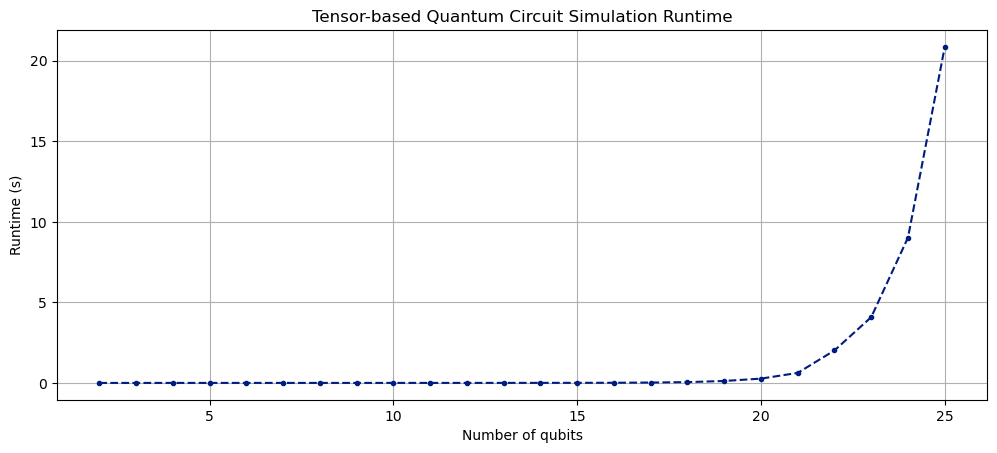

In [34]:
qubits, times = plot_tensor_simulation(25)

Major improvement as it runs for >25 qubits which would have been very difficult using traditional numpy implementation